In [54]:
%%capture
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn import metrics
from xgboost import XGBClassifier as XGB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
import tensorflow as tf

EXTRACTED_FEATURES_FILE = '../data/extracted_features_ent05.csv'
pd.options.display.max_columns = None
pd.options.display.max_rows = None
tf.random.set_seed(1)
plt.rcParams['figure.dpi'] = 300

In [6]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df[['Subject', 'File', 'Gender', 'Emotion', 'Emotion_Id', 'var_mfcc15', 'min_mfcc17', 'std_chroma_stft', 'mean_zcr', 'min_zcr', 'var_mfcc4', 'spikes_spec_cent', 'var_spec_bw', 'max_mfcc6', 'min_mfcc19', 'max_mfcc13', 'max_mfcc5', 'var_mfcc9', 'min_mfcc7', 'var_mfcc1', 'max_mfcc1', 'max_mfcc9', 'var_mel_spect', 'mean_spec_cont', 'var_mfcc2', 'max_mfcc10', 'min_spec_cent', 'var_mfcc14', 'var_mfcc3']]
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 1260


,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,210
disgust,1,210
fear,2,210
happiness,3,210
sadness,4,210
surprise,5,210


In [47]:
def get_metrics(y_labels, y_pred, draw_corr_matrix=True):
    table = [
        ["Accuracy", round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)],
        ["F1 score macro", round(metrics.f1_score(y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(metrics.matthews_corrcoef(y_labels, y_pred), 3)],
    ]
    print(tabulate(table, headers=["Metric","Value"]))

    if draw_corr_matrix:	
        ticks =  ['0 - anger', '1 - disgust', '2 - fear', '3 - happiness', '4 - sadness', '5 - surprise']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix Real vs. Predicted Labels")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()

# Categorical Problem

## Models

### Simple Random Forests

In [48]:
def categorical_cross_validation(get_new_model, cv=5, draw_corr_matrix=True):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,4:]
    y = df.iloc[:,3:4]
    all_y_pred = []
    all_y_labels = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

Metric               Value
-----------------  -------
Accuracy            47.7
F1 score macro      46.73
Precision           47.25
Recall              47.7
Matthews corrcoef    0.375


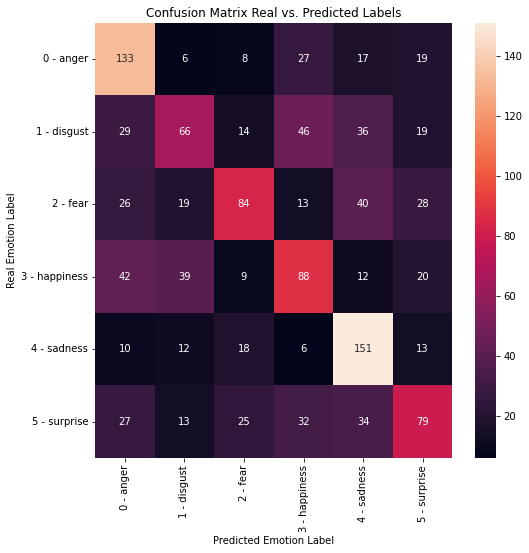

In [49]:
def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
categorical_cross_validation(get_new_model)

Metric               Value
-----------------  -------
Accuracy            45.56
F1 score macro      45.28
Precision           45.25
Recall              45.56
Matthews corrcoef    0.347


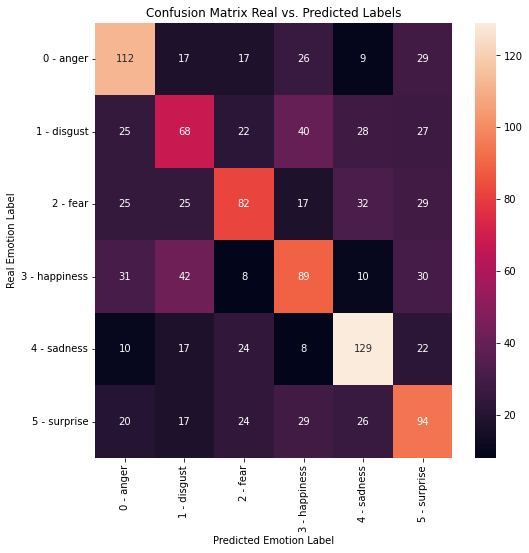

In [50]:
def get_new_model():
    return GradientBoostingClassifier(random_state=1)
categorical_cross_validation(get_new_model)

Metric               Value
-----------------  -------
Accuracy            48.41
F1 score macro      47.46
Precision           47.82
Recall              48.41
Matthews corrcoef    0.383


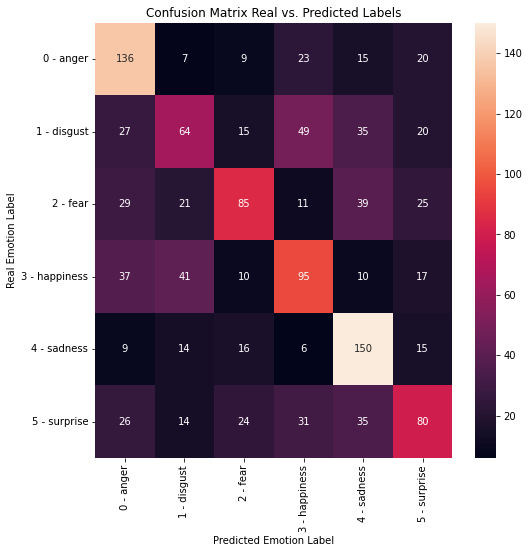

In [51]:
def get_new_model():
    return AdaBoostClassifier(random_state=1, base_estimator=RandomForest(n_estimators=512, n_jobs=-1, random_state=1))
categorical_cross_validation(get_new_model)

Metric               Value
-----------------  -------
Accuracy            47.78
F1 score macro      46.79
Precision           47.07
Recall              47.78
Matthews corrcoef    0.375


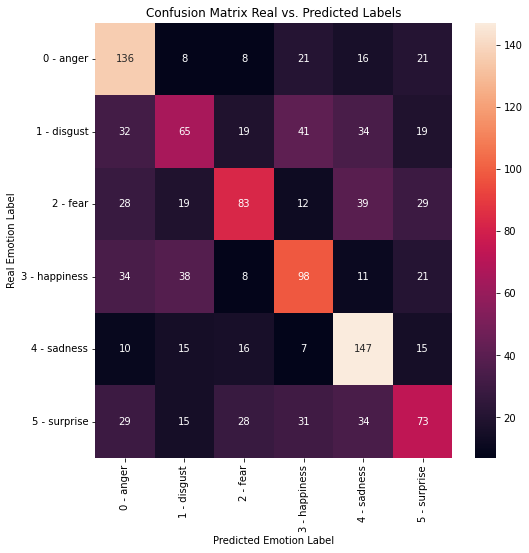

In [52]:
def get_new_model():
    return BalancedRandomForestClassifier(n_estimators=512, random_state=1)
categorical_cross_validation(get_new_model)

Metric               Value
-----------------  -------
Accuracy            45.4
F1 score macro      44.91
Precision           44.93
Recall              45.4
Matthews corrcoef    0.346


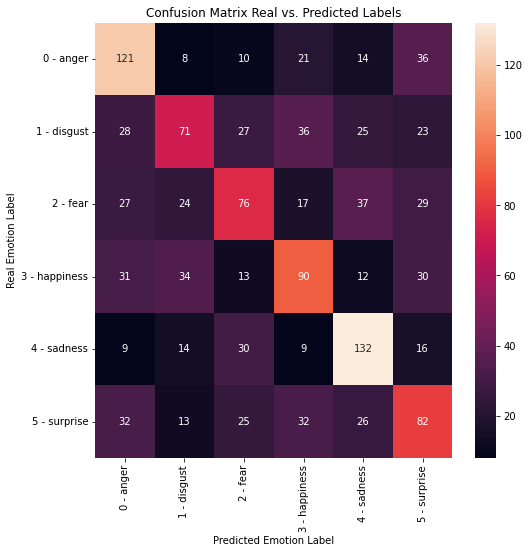

In [57]:
def get_new_model():
    return LinearDiscriminantAnalysis()
categorical_cross_validation(get_new_model)

Metric               Value
-----------------  -------
Accuracy            46.9
F1 score macro      46.64
Precision           46.55
Recall              46.9
Matthews corrcoef    0.363


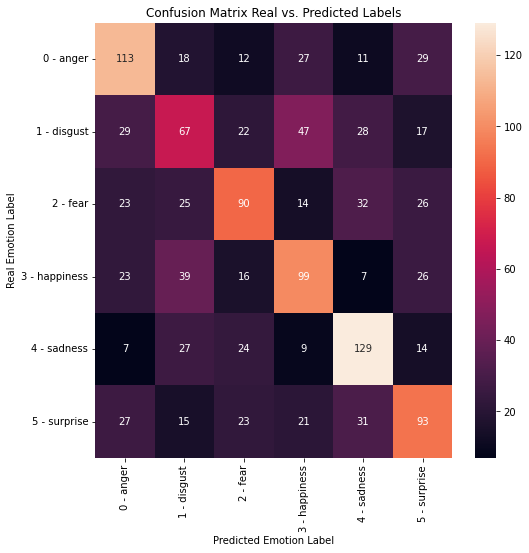

In [61]:
def get_new_model():
    return HistGradientBoostingClassifier(early_stopping=False,
                                          l2_regularization=2.188553300996835e-10,
                                          learning_rate=0.06138190336151616, max_iter=512,
                                          max_leaf_nodes=20, n_iter_no_change=0,
                                          random_state=1, validation_fraction=None,
                                          warm_start=True)
categorical_cross_validation(get_new_model)